# Recurrent neural networks

RNN은 미래를 예측하기 위해 고안된 신경망이다.

시계열 데이터를 분석해서 예측하기 위한 것으로 임의 길이를 가진 시퀀스를 다룰 수 있으며, 자연어 처리에도 유용하다.

RNN은 일반적인 feed-forward 신경망의 다음의 단점을 해결하기 위해 도입되었다.

* 순차적인 데이터를 처리할 수 없음  
* 현재 입력만이 고려됨  
* 이전의 입력을 기억할 수 없음

## 순환 뉴런

지금까지는 활성화 신호가 입력층에서 출력층 한 방향으로만 흐르는 피드포워드 신경망에 초점을 맞추었지만

순환 신경망은 뒤쪽으로 순환하는 연결도 있다는 점이 다르다.

입력을 받아 출력을 만들고, 출력을 다음 층 뿐만아니라, 자신에게도 출력을 되보내는 순환 뉴런을 생각해 보자.

각 타임 스텝 $t$ (프레임)마다 이 순환 뉴런은 $x_t$와 이전 타임 스텝의 출력인 $y_{t-1}$을 입력으로 받는다.

첫 번째 타임스텝에서는 이전 출력이 없으므로 0으로 설정.

각 순환 뉴런은 두 벌의 가중치를 지닌다.

하나는 입력 $x_t$를 위한 것이고, 다른 하나는 이전 타임 스텝의 출력 $y_{t-1}$를 위한 것이다.

아래 그림의 왼쪽은 이러한 순환 뉴런을 나타낸 것이다.

오른쪽은 시간을 축으로 하여, 시간에 따라 네트워크를 펼친 그림이다. 

* 동일한 뉴런을 복사하여 그림으로 표현한 것

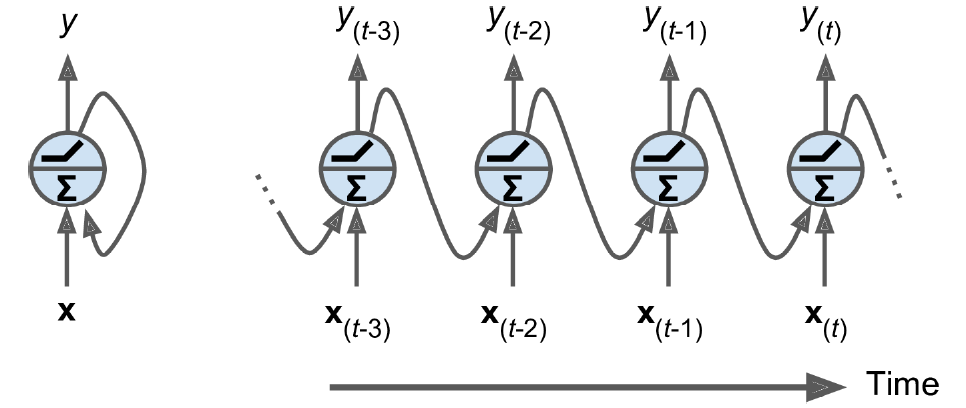

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

가장 단순한 Simple RNN은 다음과 같이 생성할 수 있다.

In [2]:
simple_rnn_model = keras.models.Sequential(
    keras.layers.SimpleRNN(units = 1, input_shape = [None, 1]))

이 모형은 일변량 시계열을 입력으로 받는 유닛 하나와 layer 하나로 구성된 RNN이다.

* ```input_shape = [None, 1]```에서 ```1```이 일변량 시계열을 입력 받음을 의미

In [3]:
simple_rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


유닛 하나에 $x_t$와 $y_{t-1}$를 위한 두 개의 parameter들과 편향을 위한 parameter까지 총 3개의 parameter가 있다.

간단한 RNN layer에서 출력되는 값을 살펴보자.

아래의 코드에서는 길이가 3인 sequence ```x```를 input으로 사용하였다.

```x```의 ```shape```은 ```(1,3,1)```로서 가장 처음의 1은 sequence의 숫자, 두 번째 3은 sequence의 길이, 마지막 1은 1변량 sequence임을 의미한다.

In [4]:
# input
x = np.array([1.0, 2.0, 3.0]).reshape(1,-1,1)
x.shape

(1, 3, 1)

In [5]:
RNN_layer1 = keras.layers.SimpleRNN(units = 1, input_shape = [None, 1])
RNN_layer1(x)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.9704554]], dtype=float32)>

```return_sequences = True```로 하면 모든 스텝별로 계산된 sequence가 출력된다.

현재 입력 sequence의 길이가 3이므로, 3개의 결과가 출력된다.

In [6]:
keras.layers.SimpleRNN(units = 1, input_shape = [None, 1], return_sequences = True)(x)

<tf.Tensor: shape=(1, 3, 1), dtype=float32, numpy=
array([[[0.6996265 ],
        [0.98470247],
        [0.9984606 ]]], dtype=float32)>

다른 shape의 input들에 대해서도 연습해 보자.

In [7]:
# two-dimensional input
x2 = np.array([[1.0, 2.0, 3.0, 4.0],
               [4.0, 3.0, 2.0, 1.0]]).reshape(1,-1,2)
x2.shape

(1, 4, 2)

In [8]:
keras.layers.SimpleRNN(units = 1, input_shape = [None, 1], return_sequences = True)(x2)

<tf.Tensor: shape=(1, 4, 1), dtype=float32, numpy=
array([[[0.75781494],
        [0.99730635],
        [0.9991724 ],
        [0.9816593 ]]], dtype=float32)>

In [9]:
# two one-dimensional input
x3 = np.array([[1.0, 2.0, 3.0, 4.0],
               [4.0, 3.0, 2.0, 1.0]]).reshape(2,-1,1)
x3.shape

(2, 4, 1)

In [10]:
keras.layers.SimpleRNN(units = 1, input_shape = [None, 1], return_sequences = True)(x3)

<tf.Tensor: shape=(2, 4, 1), dtype=float32, numpy=
array([[[-0.3509113 ],
        [-0.36448988],
        [-0.6260892 ],
        [-0.68572503]],

       [[-0.8987983 ],
        [-0.19799946],
        [-0.48916772],
        [ 0.12207324]]], dtype=float32)>

### 여러 유닛을 가지는 RNN layer

만약 layer 내의 unit의 수를 늘리고자 한다면 다음과 같이 가능하다.  

이렇게 하면 타임 스텝 $t$마다 모든 뉴런은 이전 타임 스텝의 출력을 벡터로 받게 된다.  

Input이 층 내의 모든 유닛들에 연결되고, 유닛을 통과한 출력들이 다시 모든 유닛들에 순환 연결된다.  

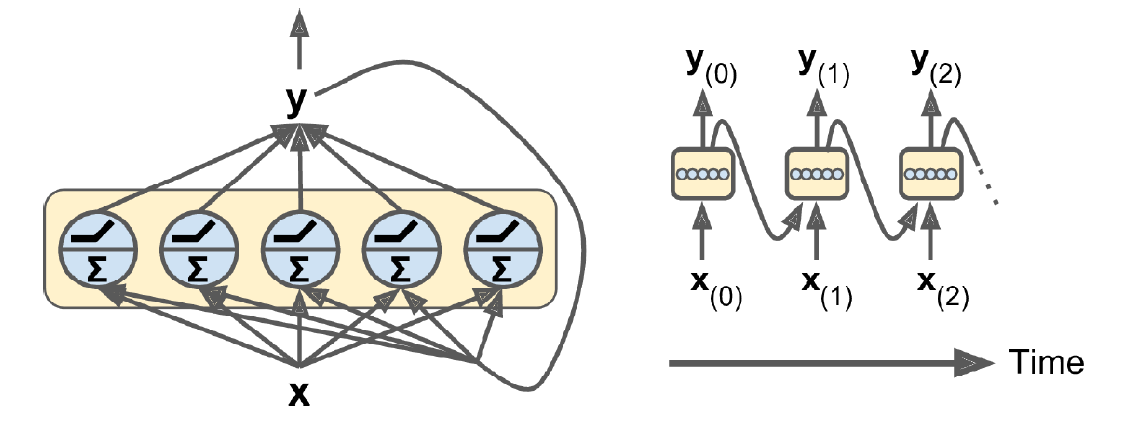

In [11]:
simple_rnn_model2 = keras.models.Sequential(
    keras.layers.SimpleRNN(units = 5, input_shape = [None, 1]))

In [12]:
simple_rnn_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_5 (SimpleRNN)    (None, 5)                 35        
                                                                 
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


위 모델에서는 각 유닛 당 총 7개의 paramter가 존재한다.   
* 각 타임 스텝에서 하나의 입력 $x_t$ 에 대한 가중치 parameter 
* 5개의 이전 스텝 출력 $y_{t-1}$에 대한 가중치 parameter
* 그리고 편향 parameter 

이러한 유닛이 총 5개 있으므로 $5 \times 7 = 35$개의 parameter가 존재한다.  

Unit이 여러 개인 RNN layer의 출력 결과를 살펴보자.  
길이가 3인 sequence ```x```를 input으로 사용하여 본다.

In [13]:
x

array([[[1.],
        [2.],
        [3.]]])

In [14]:
keras.layers.SimpleRNN(units = 5, input_shape = [None, 1])(x)

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[ 0.99873656, -0.9789105 ,  0.39291143, -0.85379565, -0.8017865 ]],
      dtype=float32)>

모든 스텝마다의 계산 결과를 보고 싶다면 ```return_sequences = True```를 사용한다.

In [15]:
keras.layers.SimpleRNN(units = 5, input_shape = [None, 1], return_sequences = True)(x)

<tf.Tensor: shape=(1, 3, 5), dtype=float32, numpy=
array([[[-0.4711787 , -0.22575957, -0.7155344 , -0.10398051,
         -0.12824878],
        [-0.8670634 , -0.3887676 , -0.9708374 , -0.665323  ,
         -0.6527878 ],
        [-0.94955206, -0.43680015, -0.9895018 , -0.9068402 ,
         -0.89689726]]], dtype=float32)>

만약 입력 $x$가 다변량이라면 그만큼 parameter 수가 늘어날 것이다.

In [16]:
simple_rnn_model3 = keras.models.Sequential(
    keras.layers.SimpleRNN(units = 5, input_shape = [None, 3]))

In [17]:
simple_rnn_model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_8 (SimpleRNN)    (None, 5)                 45        
                                                                 
Total params: 45
Trainable params: 45
Non-trainable params: 0
_________________________________________________________________


위 모델에서는 각 유닛 당 총 9개의 paramter가 존재한다.  
* 각 타임 스텝에서 3개의 입력 $x_t$에 대한 가중치 parameter
* 5개의 이전 스텝 출력 $y_{t-1}$에 대한 가중치 parameter
* 편향 parameter

이러한 유닛이 총 5개 있으므로 $5 \times 9 = 45$개의 parameter가 존재한다.  

입력이 2-dimension인 데이터에 대해 RNN layer의 출력 결과를 테스트 해 보자.

In [18]:
x2 = np.array([1.0, 4.0, 
               2.0, 5.0, 
               3.0, 6.0,
               4.0, 7.0]).reshape(1, -1, 2)
x2

array([[[1., 4.],
        [2., 5.],
        [3., 6.],
        [4., 7.]]])

In [19]:
keras.layers.SimpleRNN(units = 3, input_shape = [None, 2])(x2)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[ 1.        , -0.99601954, -0.99982077]], dtype=float32)>

In [20]:
keras.layers.SimpleRNN(units = 3, input_shape = [None, 2], return_sequences = True)(x2)

<tf.Tensor: shape=(1, 4, 3), dtype=float32, numpy=
array([[[-0.61591977,  0.88850427, -0.9999473 ],
        [ 0.5841852 ,  0.9953969 , -0.99999887],
        [ 0.247503  ,  0.9982373 , -1.        ],
        [ 0.73515445,  0.9994138 , -1.        ]]], dtype=float32)>

### Deep RNN

Layer들을 여러 개 쌓아 Deep RNN을 만들어 사용하곤 한다. 

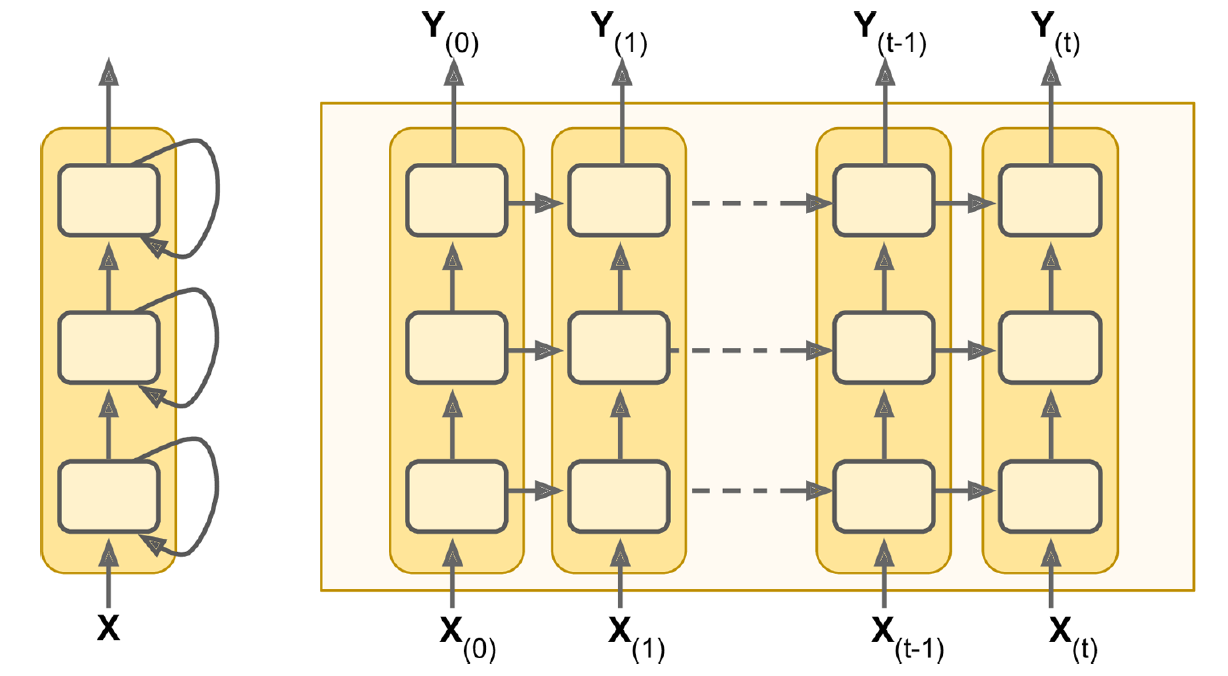

아래 예제 코드에서는 ```return_sequences=True```로 하여 step 별로 생성되는 sequence들을 전부 다음 layer로 전달한다.

In [21]:
## 예제 코드
model = keras.models.Sequential([
    keras.layers.SimpleRNN(30, return_sequences=True, input_shape=[None, 2]),
    keras.layers.SimpleRNN(15, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

In [22]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_11 (SimpleRNN)   (None, None, 30)          990       
                                                                 
 simple_rnn_12 (SimpleRNN)   (None, None, 15)          690       
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, 1)                 17        
                                                                 
Total params: 1,697
Trainable params: 1,697
Non-trainable params: 0
_________________________________________________________________


In [23]:
# 첫번째 layer의 파라미터 수 
(2 + 30 + 1) * 30

990

In [24]:
# 두번째 layer의 파라미터 수 
(30 + 15 + 1) * 15

690

In [25]:
# 마지막 layer의 파라미터 수
15 + 1 + 1

17

### 시계열 생성 예제

시계열을 입력 받아 예측하는 RNN을 구현해 보기 위해, 먼저 임의의 시계열을 생성하는 함수를 만들어 보겠다.

아래 코드에서 ```...```는 ellipsis라고 불리우며, 여러 차원을 한꺼번에 선택할 때 사용한다.

```np.newaxis```는 차원을 증가시켜 준다.

In [26]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [27]:
generate_time_series(batch_size = 1, n_steps = 5)

array([[[ 0.406847  ],
        [ 0.533558  ],
        [-0.38127986],
        [-0.53792584],
        [ 0.3376596 ]]], dtype=float32)

In [28]:
generate_time_series(2, 5).shape

(2, 5, 1)

#### 마지막 값 예측하기

위 함수를 이용하여 50+1 step의 시계열을 생성한다.  
이중 처음 50개의 step의 값들을 이용하여 마지막 하나의 값을 예측하는 예제를 진행할 것이다.

In [29]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(batch_size = 10000, n_steps = n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [30]:
y_train

array([[-0.35489398],
       [ 0.11629631],
       [-0.35395944],
       ...,
       [ 0.04946356],
       [-0.26231018],
       [ 0.60062087]], dtype=float32)

In [31]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

랜덤하게 생성된 시계열을 그려 보자. 마지막 값은 x로 표현하였다.

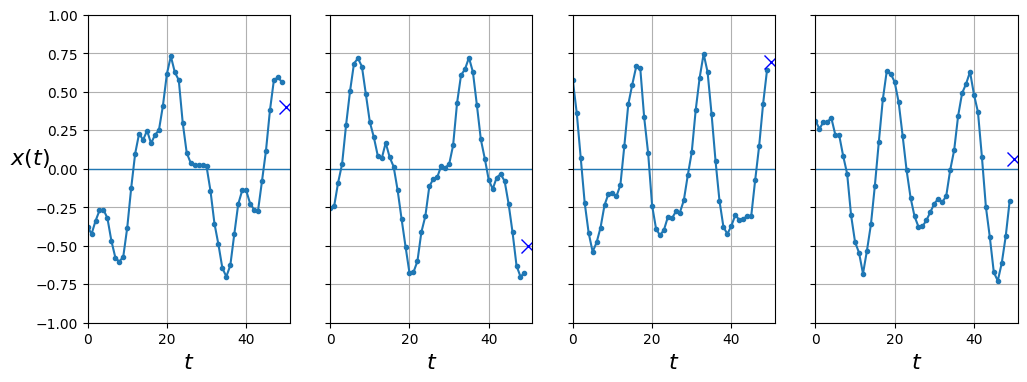

In [32]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(12, 4))
for col in range(4):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()

단순 예측 (naive forecasting), 다시 말해, 가장 나중에 관찰된 값을 다음 예측에 그대로 이용해 보자.

즉, $\hat t_{51} = t_{50}$를 이용한다.

이 방법을 이용하여 MSE를 측정했을 때, 비교적 괜찮은 정확도를 가지고 있는 것을 볼 수 있다.

In [33]:
y_pred = X_valid[:, -1]  #마지막 값
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

아래 그림에서 붉은 동그라미가 마지막 값을 이용한 단순 예측값이고, x로 표현된 좌표는 실제 값이다.

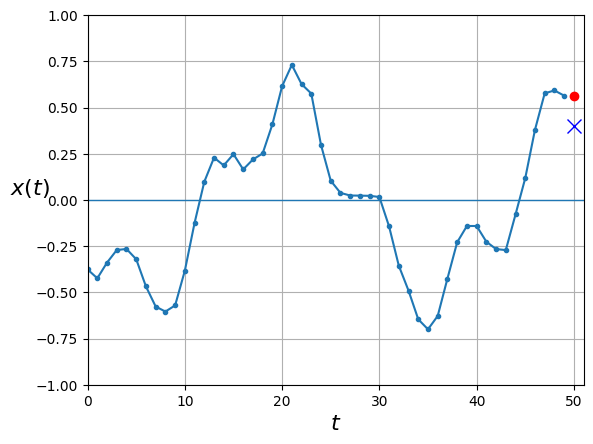

In [34]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

훈련 데이터 하나는 길이 50의 실현된 시계열이다. 

In [35]:
X_train[:1]

array([[[ 0.4596948 ],
        [ 0.31486678],
        [ 0.12497123],
        [-0.1039134 ],
        [-0.33817387],
        [-0.53167135],
        [-0.65472883],
        [-0.6680997 ],
        [-0.6068115 ],
        [-0.50168324],
        [-0.27951923],
        [-0.15070675],
        [ 0.01001816],
        [ 0.11860766],
        [ 0.09566415],
        [ 0.1479297 ],
        [ 0.16850619],
        [ 0.19524719],
        [ 0.22094081],
        [ 0.38448656],
        [ 0.4021102 ],
        [ 0.5566975 ],
        [ 0.55000687],
        [ 0.47437248],
        [ 0.29733396],
        [ 0.13306592],
        [-0.1292547 ],
        [-0.36367297],
        [-0.49515054],
        [-0.65279794],
        [-0.6665792 ],
        [-0.5604573 ],
        [-0.50344354],
        [-0.28775147],
        [-0.12684062],
        [-0.0095053 ],
        [ 0.12024356],
        [ 0.18013756],
        [ 0.1559989 ],
        [ 0.1756968 ],
        [ 0.217454  ],
        [ 0.30272725],
        [ 0.38143268],
        [ 0

```keras.layers.SimpleRNN```를 이용하여 간단한 RNN을 구현할 수 있다.  

1차원 시계열이므로, ```input_shape = [None, 1]```로 하여, 유닛 하나만 있는 RNN에 훈련 데이터 하나 ```X_train[:1]```를 적용해 계산해 보자.

* 임의의 길이의 시계열 input이 입력될 수 있으므로, ```None```을 이용하였음 

아래 코드에서는 가장 마지막 스텝의 값만 반환된다.

* ```srnn_layer(X_train[0])```로 하면 에러가 발생하니 주의

In [36]:
srnn_layer = keras.layers.SimpleRNN(units = 1, input_shape = [None, 1])
srnn_layer(X_train[:1])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.30331257]], dtype=float32)>

```return_sequences=True```로 하면 모든 step에 대한 출력 결과를 모두 반환하도록 할 수 있다.

In [37]:
keras.layers.SimpleRNN(units = 1, input_shape = [None, 1], return_sequences=True)(X_train[:1])

<tf.Tensor: shape=(1, 50, 1), dtype=float32, numpy=
array([[[ 0.08483101],
        [ 0.14210743],
        [ 0.16373761],
        [ 0.14351775],
        [ 0.08078513],
        [-0.01756285],
        [-0.1377939 ],
        [-0.2555863 ],
        [-0.35209715],
        [-0.41769755],
        [-0.43771735],
        [-0.4346336 ],
        [-0.4076423 ],
        [-0.36764902],
        [-0.33633372],
        [-0.29949918],
        [-0.2620688 ],
        [-0.22218321],
        [-0.17935197],
        [-0.10780814],
        [-0.03341243],
        [ 0.06945474],
        [ 0.16954318],
        [ 0.25176248],
        [ 0.2974903 ],
        [ 0.31140915],
        [ 0.27983153],
        [ 0.20941406],
        [ 0.1172778 ],
        [-0.00347825],
        [-0.12610863],
        [-0.22582272],
        [-0.30855793],
        [-0.34678698],
        [-0.3542106 ],
        [-0.34165838],
        [-0.30897826],
        [-0.26887983],
        [-0.23551726],
        [-0.20027252],
        [-0.1586947 ],
     

이 모형에서는 가장 마지막 스텝 직후의 시계열 값을 예측하는 것이 목표이다.

훈련을 위해 모형을 만들자.

In [38]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(units = 1, input_shape=[None, 1])
])

가장 간단한 형태의 RNN에는 3개의 parameter가 있다. 
* 입력 $x_{(t)}$을 위한 것, 이전 타임 스텝의 출력 $y_{(t-1)}$을 위한 것, 편향 $b$에 해당하는 것

In [39]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_16 (SimpleRNN)   (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


$y$가 양적 변수이기 때문에 loss function을 ```"mse"```로 하였다.

In [40]:
optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0967 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0369 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0253 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0198 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0166 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0116 - val_loss: 0.0110

Validation set에 대한 MSE 측정 결과

In [41]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 1ms/step - loss: 0.0109


0.010881561785936356

In [42]:
# Validation set에 대한 예측값
y_pred = model.predict(X_valid)
y_pred

63/63 [==============================] - 0s 968us/step


array([[ 0.51761144],
       [-0.603583  ],
       [ 0.6157377 ],
       ...,
       [-0.1806495 ],
       [-0.18601239],
       [ 0.50569546]], dtype=float32)

일부를 선택하여, 실제값과 예측값을 비교하는 그래프를 생성해 보자.  

실제 값은 X 모양으로, 예측값은 동그라미로 표현하였다.

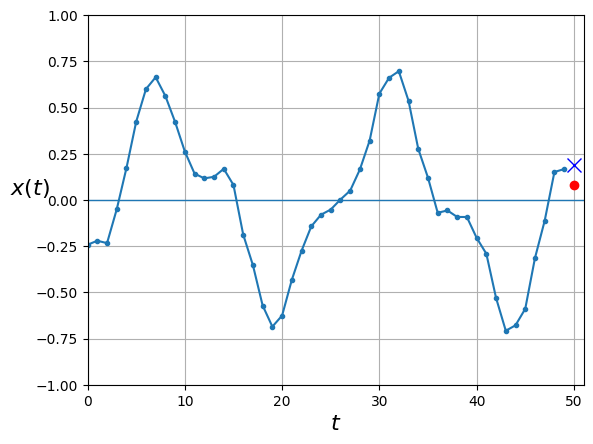

In [43]:
plot_series(X_valid[4, :, 0], y_valid[4, 0], y_pred[4, 0])
plt.show()

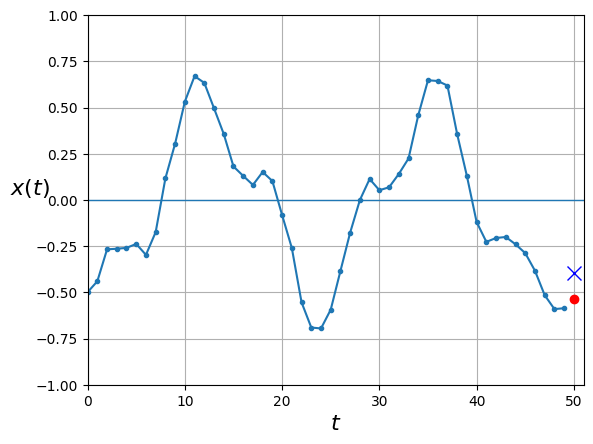

In [44]:
plot_series(X_valid[5, :, 0], y_valid[5, 0], y_pred[5, 0])
plt.show()

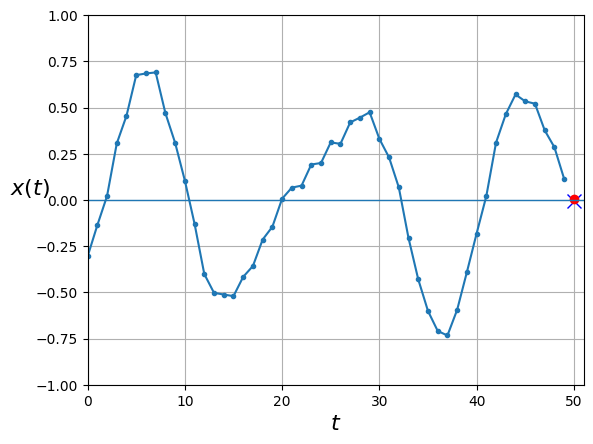

In [45]:
plot_series(X_valid[20, :, 0], y_valid[20, 0], y_pred[20, 0])
plt.show()

## 심층 RNN

RNN을 여러 층으로 쌓을 수 있다. 이를 심층 RNN이라 한다.

Keras로 쉽게 구현할 수 있다.  

아래 코드에서처럼 마지막 층은 Dense 층으로 하는 것이 더 유용하다고 알려져 있다.

첫 번째 ```SimpleRNN```에서 두 번째 ```SimpleRNN```으로 전달할 때, 모든 time step에서의 출력을 전달하기 위해,```return_sequences=True```를 사용하였다.

In [46]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(units=20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(units=20),
    keras.layers.Dense(1)
])

예를 들어, 이 모형의 첫번째 layer에 길이 50의 시계열 하나를 입력하면, 뉴런 20개가 각각 50 길이의 결과를 출력한다.

In [47]:
model.get_layer(index = 0)(X_train[:1]).shape

TensorShape([1, 50, 20])

In [48]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_17 (SimpleRNN)   (None, None, 20)          440       
                                                                 
 simple_rnn_18 (SimpleRNN)   (None, 20)                820       
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


앞에서 살펴본 것처럼 첫 번째 layer의 각 unit에는 총 22개의 parameter가 존재한다.  
* 각 unit에는 20개의 뉴런에서 출력되는 $y_{(t-1)}$
* 1개의 $x_{(t)}$
* 그리고 1개의 편향을 담당하는 parameter 

이러한 unit이 총 20개 존재하므로 첫 번째 layer의 총 paramter 수는 $22 \times 20 = 440$개이다.  

두 번째 layer에는 각 unit에는 총 41개의 parameter가 존재한다.  
* 해당 layer의 20개 unit에서 출력되는 $y_{(t-1)}$
* 이전 layer의 output에서 나오는 출력값 20개
* 그리고 1개의 편향까지 

이러한 unit이 총 20개 존재하므로 두 번째 layer의 총 paramter 수는 $41 \times 20 = 820$개이다.  

마지막 dense 층에는 20의 input과 하나의 bias를 처리하는 한 개의 unit만 있으므로 총 21개의 parameter가 있다.

In [ ]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0232 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0029

In [ ]:
model.evaluate(X_valid, y_valid)

마찬가지로 X 표시는 실제값, 붉은 원은 RNN을 이용한 예측값이다.

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[4, :, 0], y_valid[4, 0], y_pred[4, 0])
plt.show()

In [ ]:
plot_series(X_valid[5, :, 0], y_valid[5, 0], y_pred[5, 0])
plt.show()

In [ ]:
plot_series(X_valid[25, :, 0], y_valid[25, 0], y_pred[25, 0])
plt.show()

### 여러 스텝에 대한 예측

이전에는 한 스텝 미래에 대한 예측을 하였다면, 이제는 여러 스텝의 미래를 예측하는 훈련을 해 보자.

이를 위한 첫번째 방법으로 이미 훈련한 모델을 사용하여 다음 값을 예측한 다음 이 값을 입력으로 추가하여 다시 다음 값을 예측하는 행위를 반복하여 여러 스텝을 예측할 수 있다.

이 방법의 단점은 보다 더 미래에 대한 예측일수록 오차가 누적될 수 있다.  

앞서 훈련한 모델을 그대로 이용하여 10개의 미래 step에 대해 예측을 진행해 보자.

예측된 값을 계속 연장하면서 다음 step을 예측하고 있다.

새로운 time series를 하나 생성하여 살펴 보겠다.

In [ ]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)  
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new

In [ ]:
X.shape

In [ ]:
Y_new.shape

아래 코드에서 50개의 과거자료를 prediction에 사용한다는 의미로 ```X[:, step_ahead:]```를 사용하였다.

```X[:, step_ahead:]```의 길이는 50이다.

한편, ```model.predict(X[:, step_ahead:])```의 ```shape```은 ```(1,1)```인데, ```X```와 연결하기 위해 ```shape```을 ```(1,1,1)```로 변환해 준다.


In [ ]:
for step_ahead in range(10):
    
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]  # 새로운 차원을 추가하기 위해 np.newaxis 이용

    # 예측한 y값을 이전의 X들에 연결한다.
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]  #50이후의 값들

In [ ]:
# 10개의 미래 step에 대해 예측
Y_pred

In [ ]:
Y_pred.shape

In [ ]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bx-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "ro-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

또다른 방법으로 RNN을 훈련하여 다음 값 10개를 한 번에 예측하는 것이다.

먼저 target을 다음 10개의 값으로 이루어진 벡터로 바꾸어야 한다.

In [ ]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10) # 60개를 생성

X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [ ]:
Y_train.shape

마지막에 1개가 아닌 10개의 유닛을 가진 출력층이 필요하다.

나머지는 앞의 모형과 동일하다.

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

In [ ]:
model.summary()

첫 번째 RNN layer에서는 $(20 + 1 + 1) \times 20 = 440$개의 paramter가 있다.  
 * $(순환입력 + 입력 + 편향) \times 뉴런의 수$

두 번째 RNN layer에서는 $(20 + 20 + 1) \times 20 = 820$개의 paramter가 있다.
 * $(순환입력 + 입력 + 편향) \times 뉴런의 수$

In [ ]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

새로운 시계열을 하나 랜덤하게 생성한다.

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]

In [ ]:
Y_pred = model.predict(X_new)
Y_pred

In [ ]:
# plot_multiple_forecasts 함수로 그리기 위해 차원을 하나 추가하였다.
Y_pred = Y_pred[..., np.newaxis]
Y_pred

이 모델은 잘 작동하는 편이다.

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

#### 시퀀스-투-시퀀스 훈련

하지만 개선의 여지가 더 있다.

마지막 타임 스텝에서만 다음 10개의 값을 예측하도록 훈련하는 대신, 모든 타임 스텝에서 다음 10개의 값을 예측하는 훈련을 할 수 있다.

시퀀스-투-시퀀스 훈련이라고 한다. (앞의 예제는 시퀀스-투-벡터)

구체적으로 보자면 타임 스텝 0에서, "타임 스텝 1에서 10까지의 예측이 담긴 벡터"를 예측할 것이다.

그 다음 타임 스텝 1에서 이 모델은 타임 스텝 2에서 11까지 예측할 것이다.

그 다음 타임 스텝 2에서 이 모델은 타임 스텝 3에서 12까지 예측할 것이다.

In [ ]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]

In [ ]:
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [ ]:
Y_train[0,0,:]

In [ ]:
Y_train[0,1,:]

In [ ]:
Y_train[0,2,:]

In [ ]:
X_train[0,1:11]

In [ ]:
X_train[3,22:32]

In [ ]:
X_train.shape, Y_train.shape

```Y_train.shape```이  ```(7000, 50, 10)```인 것에 주목하라.  

* 직전의 방법에서는 ```Y_train.shape```이 ```(7000, 50, 10)````

앞의 방법에서는 가장 마지막 스텝에서의 10개의 예측에 대해서만 훈련했다면, 여기서는 모든 50번의 time step에서의 데이터를 이용해 훈련이 이루어진다.

이를 위해서는 모든 순환 층에 ```return_sequences=True```로 설정해야 한다.

아래 모형에서 모든 타임 스텝에서 출력을 Dense 층에 적용할 수 있도록 ```TimeDistributed```를 사용하였다.

```TimeDistributed``` 층은 각 타임 스텝을 별개의 샘플처럼 다루도록 한다.

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

사실 ```TimeDistributed(keras.layers.Dense()```는 ```Dense``` layer와 같은 역할을 한다.

```keras.layers.TimeDistributed(keras.layers.Dense(10))```를

```keras.layers.Dense(10))```로 바꾸어도 사실상 거의 같은 결과를 얻는다.

* 아래 간단한 예제를 통해 비교해 보자.


In [ ]:
inp = np.array([[[1,1],
                 [0,1],
                 [1,0]]])
inp.shape

In [ ]:
dense_layer = keras.layers.Dense(3)

In [ ]:
dense_layer(inp)

In [ ]:
td_layer = keras.layers.TimeDistributed(dense_layer)
td_layer(inp)

```model.summary()``` 마지막 output shape이 ```(None, None, 10)```의 3차원임을 주목하라.

실제로는, ```(batch size, number of time step, 10)```을 얻는다.

이것은 ```Y_train.shape```인  ```(7000, 50, 10)```과 같다.

In [ ]:
model.summary()

아래와 같은 RNN을 설계하는 방안도 생각해 볼 수 있다.

단지 마지막 layer가 RNN이므로 마지막 결과의 output이 순환적으로 학습에 다시 이용된다는 차이점이 있다.

In [ ]:
model2 = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(10, return_sequences=True),
])
model2.summary()

대략적으로 어떤 식으로 계산되는지 살펴보자. 

Training set 중의 하나의 시계열만 뽑아, input으로 넣어보자.

In [ ]:
first_output = model.get_layer(index=0)(X_train[:1, :]) # 첫 번째 times series
first_output.shape

In [ ]:
second_output = model.layers[1](first_output)

```TimeDistributed``` 층으로 입력되는 데이터의 shape은 (배치크기, 타입스텝의 수, ...)으로 이루어져 있다.

In [ ]:
# (batch size, time step, ...)
second_output.shape

TimeDistributed 층에서는 각 time step 별 출력값들을 개별 데이터로 인식하여 훈련에 사용할 것이다. 

즉, 이 예제 구문에서는 1개의 $50 \times 20$ 데이터라기보다는 50개의 데이터 (그런데 각 데이터의 크기는 20)를 독립적으로 입력으로 받는 것처럼 간주한다.

In [ ]:
third_output = model.layers[2](second_output)
third_output.shape

마지막 output의 shape은 ```[1,50,10]```이다.  
즉, 50개의 각 $x_t$에 대해 총 10개 씩의 output 즉, $x_{t+1}, \cdots, x_{t+10}$을 계산하였고, 이 값을 실제 관찰된 시계열 값들과 비교하여 훈련에 사용한다.

In [ ]:
# model2도 마찬가지
model2.layers[2](second_output).shape

훈련하는 동안에는 모든 출력이 필요하지만, 예측과 평가에는 마지막 타임 스텝의 출력만이 이용된다.  

아래 코드에서는 훈련과 평가에 사용하는 MSE들을 서로 조금 다르게 설정하였다.

훈련에는 모든 time step에서 MSE를 측정하여 이를 줄이도록 모형 parameter들을 적합하겠지만,

```metrics```으로서 평가에 사용하는 mse 함수는 마지막 custom function으로 마지막 step에서의 예측값 10개를 이용하여 계산한다.

User-defined metric 함수는 ```metric_fn(y_true, y_pred)```의 형태로 작성한다.

In [ ]:
# 평가에 사용하는 mse, 마지막 예측의 정확도만 이용

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1, :], Y_pred[:, -1, :])

In [ ]:
model.compile(loss="mse",   # 훈련에 필요한 mse
              optimizer=keras.optimizers.Adam(learning_rate=0.01), 
              metrics=[last_time_step_mse])  # 평가에 필요한 mse

history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

시계열 하나를 추가로 생성하여, 예측과 실제를 비교하는 그래프를 그려 보자.

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]

X_new.flatten(), Y_new.flatten()

In [ ]:
Y_pred = model.predict(X_new)

이렇게 얻어진 ```Y_pred```은 모든 time step에서 직후 10개에 대한 예측들을 담고 있다.

In [ ]:
Y_pred.shape

첫 번째 time step 이후의 10개에 대한 예측, 즉, $x_2, x_3, \cdots, x_{11}$에 대한 예측

In [ ]:
Y_pred[:, 0]

In [ ]:
Y_pred[:, 0, :]

두 번째 time step 이후의 예측, 즉, $x_3, x_3, \cdots, x_{12}$에 대한 예측

In [ ]:
# 두 번째 time step 이후의 예측
Y_pred[:, 1]

마지막 10개에 대한 예측

In [ ]:
Y_pred[:, 49]

In [ ]:
Y_pred[:, -1]

실제 실현된 마지막 10개

In [ ]:
Y_new

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred[:, -1][..., np.newaxis])
plt.show()

### LSTM (Long short-term memory)

RNN을 거치며 일부 정보는 매 훈련 스텝 후 사라진다. 어느 정도 시간이 지나면 RNN의 상태는 사실상 첫 번째의 입력의 흔적을 가지고 있지 않다. 

이에 장기 메모리를 가진 여러 셀이 연구되었다. 

In [ ]:
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences = True, input_shape = [None, 1]),
    keras.layers.LSTM(20, return_sequences = True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [ ]:
model.summary()